<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h2>Analysis Report to management | Apprentice Chef  </h2>
<h4>Machine Learning</h4><br>
Christian Romero - MsBA 2
Hult International Business School<br><br>

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

In [125]:
#Importing my libraries, import dataset and add a wider screen option for better visualization

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

#Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf # regression modeling

from sklearn.model_selection import train_test_split # train/test split

import sklearn.linear_model

from sklearn.ensemble import GradientBoostingClassifier #GBM

from sklearn.inspection import permutation_importance 

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import roc_auc_score

# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV    
from sklearn.metrics import make_scorer  

# libraries for classification trees
from sklearn.tree import export_graphviz             # exports graphics
from sklearn.externals.six import StringIO           # saves objects in memory
from IPython.display import Image                    # displays on frontend
import pydotplus 

#Import our data

file = "Apprentice_Chef_Dataset.xlsx"

dataset = pd.read_excel(io=file)

#Functions
def Sort(sub_li): 
    sub_li.sort(key = lambda x: x[1]) 
    return sub_li 

def text_split_feature(col, df, sep=' ', new_col_name='NUMBER_OF_NAMES'): 
    df[new_col_name] = 0 
    for index, val in df.iterrows():     
        df.loc[index, new_col_name] = len(df.loc[index, col].split(sep = ' '))
  

def display_tree(tree, feature_df, height = 500, width = 800):  
    dot_data = StringIO()
    export_graphviz(decision_tree      = tree,
                    out_file           = dot_data,
                    filled             = True,
                    rounded            = True,
                    special_characters = True,
                    feature_names      = feature_df.columns)  
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    img = Image(graph.create_png(),
                height = height,
                width  = width)
    return img

def plot_feature_importances(model, train):
    n_features = train.shape[1]
    fig, ax = plt.subplots(figsize=(12,9))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(pd.np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature") 
    

def visual_cm(true_y, pred_y, labels = None):
    lbls = labels
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y)

    sns.heatmap(cm,
                annot       = True,
                xticklabels = lbls,
                yticklabels = lbls,
                cmap        = 'Blues',
                fmt         = 'g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()

# Revenue analysis - Regression Model (ARD)

In [126]:
#Transformations, flags and feature engineering

#FLAGGING MISSING VALUES
for column in dataset:
    if dataset[column].isnull().astype(int).sum() > 0:
        dataset['m_'+column] = dataset[column].isnull().astype(int)

#Log transformations
dataset['LOG_REV'] = np.log10(dataset["REVENUE"])
dataset['LOG_AVG_PREP_VID_TIME'] = np.log10(dataset['AVG_PREP_VID_TIME'])
dataset['LOG_TOTAL_MEALS_ORDERED'] = np.log10(dataset['TOTAL_MEALS_ORDERED'])
dataset['TOTAL_PHOTOS_VIEWED'] = dataset.TOTAL_PHOTOS_VIEWED.mask(dataset.TOTAL_PHOTOS_VIEWED == 0, 0.01)
dataset["LOG_TOTAL_PHOTOS_VIEWED"] = np.log10(dataset['TOTAL_PHOTOS_VIEWED'])
dataset['LOG_AVG_TIME_PER_SITE_VISIT'] = np.log10(dataset['AVG_TIME_PER_SITE_VISIT'])
dataset['LOG_MEDIAN_MEAL_RATING'] = np.log10(dataset['MEDIAN_MEAL_RATING'])
dataset['LOG_LARGEST_ORDER_SIZE'] = np.log10(dataset['LARGEST_ORDER_SIZE'])
dataset['MASTER_CLASSES_ATTENDED'] = dataset.MASTER_CLASSES_ATTENDED.mask(dataset.MASTER_CLASSES_ATTENDED == 0, 0.01)
dataset["LOG_MASTER_CLASSES_ATTENDED"] = np.log10(dataset['MASTER_CLASSES_ATTENDED'])
dataset['LOG_CONTACTS_W_CUSTOMER_SERVICE'] = np.log10(dataset['CONTACTS_W_CUSTOMER_SERVICE'])
dataset['LOG_PRODUCT_CATEGORIES_VIEWED'] = np.log10(dataset['PRODUCT_CATEGORIES_VIEWED'])
dataset['LOG_PC_LOGINS'] = np.log10(dataset['PC_LOGINS'])
dataset['CANCELLATIONS_BEFORE_NOON'] = dataset.CANCELLATIONS_BEFORE_NOON.mask(dataset.CANCELLATIONS_BEFORE_NOON == 0, 0.01)
dataset["LOG_CANCELLATIONS_BEFORE_NOON"] = np.log10(dataset['CANCELLATIONS_BEFORE_NOON'])
dataset['TASTES_AND_PREFERENCES'] = dataset.TASTES_AND_PREFERENCES.mask(dataset.TASTES_AND_PREFERENCES == 0, 0.01)
dataset['LOG_TASTES_AND_PREFERENCES'] = np.log10(dataset['TASTES_AND_PREFERENCES'])
dataset['WEEKLY_PLAN'] = dataset.WEEKLY_PLAN.mask(dataset.WEEKLY_PLAN == 0, 0.01)
dataset['LOG_WEEKLY_PLAN'] = np.log10(dataset['WEEKLY_PLAN'])
dataset['EARLY_DELIVERIES'] = dataset.EARLY_DELIVERIES.mask(dataset.EARLY_DELIVERIES == 0, 0.01)
dataset["LOG_EARLY_DELIVERIES"] = np.log10(dataset['EARLY_DELIVERIES'])
dataset['CANCELLATIONS_AFTER_NOON'] = dataset.CANCELLATIONS_AFTER_NOON.mask(dataset.CANCELLATIONS_AFTER_NOON == 0, 0.01)
dataset['LOG_CANCELLATIONS_AFTER_NOON'] = np.log10(dataset['CANCELLATIONS_AFTER_NOON'])
dataset['LATE_DELIVERIES'] = dataset.LATE_DELIVERIES.mask(dataset.LATE_DELIVERIES == 0, 0.01)
dataset["LOG_LATE_DELIVERIES"] = np.log10(dataset['LATE_DELIVERIES'])
dataset['MOBILE_LOGINS'] = dataset.MOBILE_LOGINS.mask(dataset.MOBILE_LOGINS == 0, 0.01)
dataset['LOG_MOBILE_LOGINS'] = np.log10(dataset['MOBILE_LOGINS'])
dataset['LOG_UNIQUE_MEALS_PURCH'] = np.log10(dataset['UNIQUE_MEALS_PURCH'])
dataset['LOG_AVG_CLICKS_PER_VISIT'] = np.log10(dataset['AVG_CLICKS_PER_VISIT'])


#Creating flags for thresholds
dataset["VIEW_PHOTOS"] = 0
dataset["FEW_MEALS_ORDERED"] = 0
dataset['FEW_TIME'] = 0

for index, value in dataset.iterrows():

    if dataset.loc[index, 'TOTAL_MEALS_ORDERED'] <= 16:
        dataset.loc[index, 'FEW_MEALS_ORDERED'] = 1

    if dataset.loc[index, 'TOTAL_PHOTOS_VIEWED'] > 10:
        dataset.loc[index, 'VIEW_PHOTOS'] = 1
    
    if dataset.loc[index, 'AVG_TIME_PER_SITE_VISIT'] <= 25:
        dataset.loc[index, 'FEW_TIME'] = 1

#Create gender dummy
names_list = ['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'mostly_male', 'female', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'male', 'female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'unknown', 'male', 'unknown', 'female', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'female', 'female', 'unknown', 'male', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'unknown', 'andy', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'mostly_male', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'mostly_male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'female', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'mostly_male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'mostly_male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'andy', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'andy', 'male', 'unknown', 'unknown', 'male', 'male', 'female', 'female', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'female', 'unknown', 'male', 'female', 'unknown', 'unknown', 'unknown', 'female', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'mostly_female', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'female', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'female', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'mostly_female', 'unknown', 'male', 'unknown', 'female', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'female', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'female', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'male', 'male', 'mostly_male', 'male', 'male', 'male', 'male', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'andy', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'male',
              'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'male', 'unknown', 'male', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'female', 'male', 'male', 'female', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'andy', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'unknown', 'female', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'andy', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'mostly_male', 'male', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'mostly_male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'male', 'unknown', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'female', 'male', 'male', 'unknown', 'male', 'unknown', 'mostly_female', 'male', 'unknown', 'unknown', 'female', 'male', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'female', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'female', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'mostly_male', 'mostly_male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'female', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'male', 'male', 'mostly_male', 'unknown', 'unknown', 'male', 'andy', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'female', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'female', 'male', 'female', 'mostly_female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'mostly_female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'female', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'male', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'mostly_female', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'mostly_female', 'female', 'female', 'male', 'male', 'male', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'female', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'female', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'andy', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'mostly_male', 'male', 'male', 'unknown', 'male', 'unknown', 'mostly_male', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'female', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'andy', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'mostly_male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'andy', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'female', 'unknown', 'unknown',
              'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'female', 'unknown', 'unknown']

dataset['gender_guess'] = pd.Series(names_list)

dataset['MALES'] = 0
dataset['FEMALES'] = 0
dataset['UNKNOWN'] = 0

for index, value in dataset.iterrows():

    if dataset.loc[index, 'gender_guess'] == 'mostly_male' or dataset.loc[index, 'gender_guess'] == 'male':
        dataset.loc[index, 'MALES'] = 1

    if dataset.loc[index, 'gender_guess'] == 'mostly_female' or dataset.loc[index, 'gender_guess'] == 'female':
        dataset.loc[index, 'FEMALES'] = 1

    if dataset.loc[index, 'gender_guess'] == 'andy' or dataset.loc[index, 'gender_guess'] == 'unknown':
        dataset.loc[index, 'UNKNOWN'] = 1
        

#CREATE DUMMY VARIABLE CALLS EQUAL OR LOWER THAN 11.
dataset["FEW_CALLS"] = 0

for index, value in dataset.iterrows():
    
    if dataset.loc[index, 'CONTACTS_W_CUSTOMER_SERVICE'] <= 10:
        dataset.loc[index, 'FEW_CALLS'] = 1

#CREATE A DUMMY VARIABLE FOR WEEK PLANS:

dataset["FEW_WEEKS"] = 0
dataset['MEDIUM_WEEKS'] = 0
dataset["MANY_WEEKS"] = 0


for index, value in dataset.iterrows():
    
    if dataset.loc[index, 'WEEKLY_PLAN'] <= 17:
        dataset.loc[index, 'FEW_WEEKS'] = 1
        
    elif dataset.loc[index, 'WEEKLY_PLAN'] > 17 and dataset.loc[index, 'WEEKLY_PLAN'] <= 34:
        dataset.loc[index, 'MEDIUM_WEEKS'] = 1
    else:
        dataset.loc[index, 'MANY_WEEKS'] = 1

#CREATING SOME ENGINEERED FEATURES

dataset["MOBILE_PLUS_PC"] = dataset['MOBILE_LOGINS'] + dataset["PC_LOGINS"]

dataset["MOBILE_BY_PC"] = dataset['MOBILE_LOGINS']/dataset["PC_LOGINS"]

dataset['TOTAL_CANCEL'] = dataset['CANCELLATIONS_BEFORE_NOON'] + dataset["CANCELLATIONS_AFTER_NOON"]
dataset["LOG_TOTAL_CANCEL"] = np.log10(dataset["TOTAL_CANCEL"])

dataset['LOG_CONTACTS_CS_TIMES_FEW_CALLS'] = dataset['LOG_CONTACTS_W_CUSTOMER_SERVICE']*dataset["FEW_CALLS"]

dataset["TOTAL_ORDERS_UNIQUE_RATIO"] = dataset['TOTAL_MEALS_ORDERED']/dataset['UNIQUE_MEALS_PURCH']
dataset["LOG_TOTAL_ORDERS_UNIQUE_RATIO"] = np.log10(dataset["TOTAL_ORDERS_UNIQUE_RATIO"])
                                                  
                                                  
#CREATE DUMMY VARIABLES FOR THE TYPE OF EMAIL DOMAIN (PROFESSIONAL, PERSONAL, JUNK)

personal = ['gmail.com', 'yahoo.com', 'protonmail.com']
junk = ['me.com', 'aol.com', 'hotmail.com', 'live.com', 'msn.com', 'passport.com']

dataset['PERSONAL'] = 0
dataset['JUNK'] = 0
dataset['PROFESSIONAL'] = 0

for index in dataset.index.tolist():
    dataset.loc[index, 'DOMAIN'] = dataset.loc[index, 'EMAIL'].split('@')[1]
    
    if dataset.loc[index, 'DOMAIN'] in personal:
        dataset.loc[index, 'PERSONAL'] = 1   
    elif dataset.loc[index, 'DOMAIN'] in junk:
        dataset.loc[index, 'JUNK'] = 1
    else:
        dataset.loc[index, 'PROFESSIONAL'] = 1  


# DUMMY VARIABLE FOR RATING
rating_dummy = pd.get_dummies(dataset.MEDIAN_MEAL_RATING,prefix = "DUMMY_MEDIAN",drop_first = True)
dataset = pd.concat([dataset,rating_dummy], axis = 1)

# DUMMY VARIABLE ON CLASSES ATTENDED
class_dummy = pd.get_dummies(dataset.MASTER_CLASSES_ATTENDED,prefix = "DUMMY_CLASSES", drop_first = True)
class_dummy.columns = ['DUMMY_CLASSES_1', 'DUMMY_CLASSES_2', 'DUMMY_CLASSES_3']
dataset = pd.concat([dataset,class_dummy], axis = 1)

# COUNTING NUMBER OF NAMES
text_split_feature(col = 'NAME',
                   df  = dataset)

# COUNT LENGHT OF FIRST NAME and MORE THAN ONE NAME
for index in dataset.index.tolist():
    dataset.loc[index, 'LENGHT_FIRST_NAME'] = len(dataset.loc[index, 'FIRST_NAME'])

dataset["MORE_THAN_ONE_NAME"] = [1 if x>1 else 0 for x in dataset['NUMBER_OF_NAMES']]



In [127]:
#Variables for model & Train_Test_Split
variables_model1 = ['CROSS_SELL_SUCCESS',
                    'MEDIAN_MEAL_RATING',
                    'LOG_AVG_PREP_VID_TIME',
                    'LOG_TOTAL_PHOTOS_VIEWED',
                    'LOG_AVG_TIME_PER_SITE_VISIT',
                    'VIEW_PHOTOS',
                    'FEW_TIME',
                    'MALES',
                    'LOG_LARGEST_ORDER_SIZE',
                    'LOG_TOTAL_ORDERS_UNIQUE_RATIO',
                    'LOG_AVG_CLICKS_PER_VISIT',
                    'LOG_CONTACTS_W_CUSTOMER_SERVICE',
                    'LOG_CONTACTS_CS_TIMES_FEW_CALLS',
                    'DUMMY_MEDIAN_4',
                    'DUMMY_MEDIAN_5',
                    'DUMMY_CLASSES_1',
                    'DUMMY_CLASSES_2']

#Train Test Split
data_ard = dataset.loc[:, variables_model1]

target_ard = dataset.loc[:, "LOG_REV"]

# TRAIN_TEST_SPLIT for OLS
x_train_ard, x_test_ard, y_train_ard, y_test_ard = train_test_split(
            data_ard,         # x-variables
            target_ard,   # y-variable
            test_size = 0.25,
            random_state = 219)

In [115]:
# INSTANTIATING a ARD model object, fit model and test it. Print coefficients in Ascending order.
ard_model = sklearn.linear_model.ARDRegression(normalize  = False)

# FITTING the training data
ard_fit = ard_model.fit(x_train_ard, y_train_ard)

# PREDICTING on new data
ard_pred = ard_fit.predict(x_test_ard)

# saving scoring data for future use
ard_train_score = ard_model.score(x_train_ard, y_train_ard).round(4)
ard_test_score  = ard_model.score(x_test_ard, y_test_ard).round(4)
ard_test_gap = abs(ard_train_score - ard_test_score).round(4)

# zipping each feature name to its coefficient
ard_model_values = zip(data_ard.columns, ard_fit.coef_.round(decimals = 5))

# setting up a placeholder list to store model features
ard_model_lst = [('intercept', ard_fit.intercept_.round(decimals = 2))]

# printing out each feature-coefficient pair one by one
for val in ard_model_values:
    ard_model_lst.append(val)

sorted_ard_coefs = Sort(ard_model_lst)

for pair in sorted_ard_coefs:
    print(pair)


('LOG_LARGEST_ORDER_SIZE', -0.13181)
('FEW_TIME', -0.07423)
('VIEW_PHOTOS', -0.06327)
('LOG_AVG_TIME_PER_SITE_VISIT', -0.04903)
('DUMMY_MEDIAN_5', -0.01524)
('CROSS_SELL_SUCCESS', -0.01469)
('LOG_AVG_CLICKS_PER_VISIT', -0.00129)
('MALES', 0.01284)
('LOG_TOTAL_PHOTOS_VIEWED', 0.02019)
('DUMMY_CLASSES_1', 0.02828)
('MEDIAN_MEAL_RATING', 0.03379)
('DUMMY_CLASSES_2', 0.0672)
('LOG_CONTACTS_W_CUSTOMER_SERVICE', 0.08473)
('DUMMY_MEDIAN_4', 0.10038)
('LOG_TOTAL_ORDERS_UNIQUE_RATIO', 0.15907)
('LOG_CONTACTS_CS_TIMES_FEW_CALLS', 0.16386)
('LOG_AVG_PREP_VID_TIME', 0.53101)
('intercept', 1.85)


# Cross-Sell success Analysis (GBM - or Ensemble of many desicion trees)

In [128]:
# GBM Model
reduced_variables = ['REVENUE', 'TOTAL_MEALS_ORDERED', 'UNIQUE_MEALS_PURCH', 'CONTACTS_W_CUSTOMER_SERVICE', 'PRODUCT_CATEGORIES_VIEWED',\
              'AVG_TIME_PER_SITE_VISIT', 'MOBILE_NUMBER', 'CANCELLATIONS_BEFORE_NOON', 'CANCELLATIONS_AFTER_NOON', 'TASTES_AND_PREFERENCES', 'LATE_DELIVERIES', 'REFRIGERATED_LOCKER', 'AVG_PREP_VID_TIME',\
              'PERSONAL', 'JUNK', 'MALES', 'NUMBER_OF_NAMES', 'LENGHT_FIRST_NAME', 'MORE_THAN_ONE_NAME']

appchef_data3 = dataset.copy()
appchef_data3 = appchef_data3.loc[ : , reduced_variables]  #Same variables from previous iteration

# declaring response variabl
appchef_target3 = dataset.loc[:, 'CROSS_SELL_SUCCESS']

# train-test split with stratification
x_train, x_test, y_train, y_test = train_test_split(
            appchef_data3,
            appchef_target3,
            test_size    = 0.25,
            random_state = 219,
            stratify     = appchef_target3)

# declaring a hyperparameter space
learn_space        = np.arange(0.1,10.0,0.5)    # Increasing the upper bound of the learning_rate space and increasing it by steps of 5.
depth_space        = pd.np.arange(1,7,1)        # Keeping the max_depth the same
estimator_space    = pd.np.arange(10, 100, 5)
warm_start_space   = [True,False]

# creating a hyperparameter grid
param_grid = {'learning_rate' : learn_space,  
              'max_depth'     : depth_space,
              'n_estimators'  : estimator_space,
              'warm_start'    : warm_start_space}


# INSTANTIATING the model object without hyperparameters
full_gbm_grid = GradientBoostingClassifier(random_state = 219)


# GridSearchCV object
full_gbm_cv = RandomizedSearchCV(estimator = full_gbm_grid,
                                 param_distributions = param_grid,
                                 cv                  = 4,
                                 n_iter              = 20,
                                 random_state        = 219,
                                 scoring             = make_scorer(roc_auc_score,
                                                       needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
full_gbm_cv.fit(appchef_data3, appchef_target3)

# INSTANTIATING a GBM with best estimators
gbm_tuned_3 = full_gbm_cv.best_estimator_


# PREDICTING based on the testing set
gbm_tuned_3_pred = gbm_tuned_3.predict(x_test)


# saving scoring data and AUC for future use
gbm_tuned_3_train_score = gbm_tuned_3.score(x_train, y_train).round(4) # accuracy
gbm_tuned_3_test_score  = gbm_tuned_3.score(x_test, y_test).round(4)   # accuracy

gbm_tuned_3_auc         = roc_auc_score(y_true  = y_test,
                                        y_score = gbm_tuned_3_pred).round(4) # auc

<ipython-input-128-af8fa1e9c795>:22: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  depth_space        = pd.np.arange(1,7,1)        # Keeping the max_depth the same
<ipython-input-128-af8fa1e9c795>:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  estimator_space    = pd.np.arange(10, 100, 5)


In [175]:
#
model_variables = ['CROSS_SELL_SUCCESS','REVENUE', 'TOTAL_MEALS_ORDERED', 'UNIQUE_MEALS_PURCH', 'CONTACTS_W_CUSTOMER_SERVICE', 'PRODUCT_CATEGORIES_VIEWED',\
              'AVG_TIME_PER_SITE_VISIT', 'MOBILE_NUMBER', 'CANCELLATIONS_BEFORE_NOON', 'CANCELLATIONS_AFTER_NOON', 'TASTES_AND_PREFERENCES', 'LATE_DELIVERIES', 'REFRIGERATED_LOCKER', 'AVG_PREP_VID_TIME',\
              'PERSONAL', 'JUNK', 'MALES', 'NUMBER_OF_NAMES', 'LENGHT_FIRST_NAME', 'MORE_THAN_ONE_NAME']

appchefdata = dataset.copy()
appchefdata = appchefdata.loc[:, model_variables]

for i in model_variables:
    if appchefdata[i].dtype in ('float64','int64'):
        cross_1 = appchefdata.loc[( appchefdata['CROSS_SELL_SUCCESS'] == 1)]
        cross_0 = appchefdata.loc[( appchefdata['CROSS_SELL_SUCCESS'] == 0)]
        
        mean_1 = cross_1[i].mean()
        mean_2 = cross_0[i].mean()
        diffy  = mean_1 - mean_2
        
        print('')
        print('*'+i+'*')
        print('Cross Sell 1: ',end='')
        print(mean_1)
        print('Cross Sell 0: ',end='')
        print(mean_2)


*CROSS_SELL_SUCCESS*
Cross Sell 1: 1.0
Cross Sell 0: 0.0

*REVENUE*
Cross Sell 1: 2110.846707040121
Cross Sell 0: 2099.7808

*TOTAL_MEALS_ORDERED*
Cross Sell 1: 74.88039364118093
Cross Sell 0: 74.1136

*UNIQUE_MEALS_PURCH*
Cross Sell 1: 4.906888720666162
Cross Sell 0: 4.9008

*CONTACTS_W_CUSTOMER_SERVICE*
Cross Sell 1: 7.040878122634368
Cross Sell 0: 6.8624

*PRODUCT_CATEGORIES_VIEWED*
Cross Sell 1: 5.3936411809235425
Cross Sell 0: 5.3632

*AVG_TIME_PER_SITE_VISIT*
Cross Sell 1: 100.08123391370181
Cross Sell 0: 98.59734400000002

*MOBILE_NUMBER*
Cross Sell 1: 0.9008327024981075
Cross Sell 0: 0.8288

*CANCELLATIONS_BEFORE_NOON*
Cross Sell 1: 1.5820817562452676
Cross Sell 0: 1.0411839999999968

*CANCELLATIONS_AFTER_NOON*
Cross Sell 1: 0.15856169568508496
Cross Sell 0: 0.2083360000000017

*TASTES_AND_PREFERENCES*
Cross Sell 1: 0.7421953065859177
Cross Sell 0: 0.6641919999999982

*LATE_DELIVERIES*
Cross Sell 1: 2.9849810749432417
Cross Sell 0: 2.9456479999999985

*REFRIGERATED_LOCKER*
Cro

# INSIGHTS



At Apprentice Chef we want to be data-driven and analyze our customer behaviour in order to further improve our business and offerings. Leveraging a linear regression model and a GBM model (or many decision trees), we found great value in predicting but also analyzing important insights.


REVENUE insights:

 --> R-squared value = 0.762

Average preparation video time (+ effect)

• Grab Viewers in the First 3-5 Seconds.

Issues with low watching times are directly related with not being captivated in the first 5-10 secs. No intro or opening credits, straight to the most engaging opening visual to grab attention. They’re busy professionals.




Total Meals Ordered/ Unique meals purchased (+ effect)

• Set a limit for amount of unique meal sets or charge for extra unique meal sets after 3 categories. This way we increase our meals ordered/unique meals ratio, translating in improved revenues.



Let’s visualize Average preparation video time relation with revenue. 

Since we used two tr

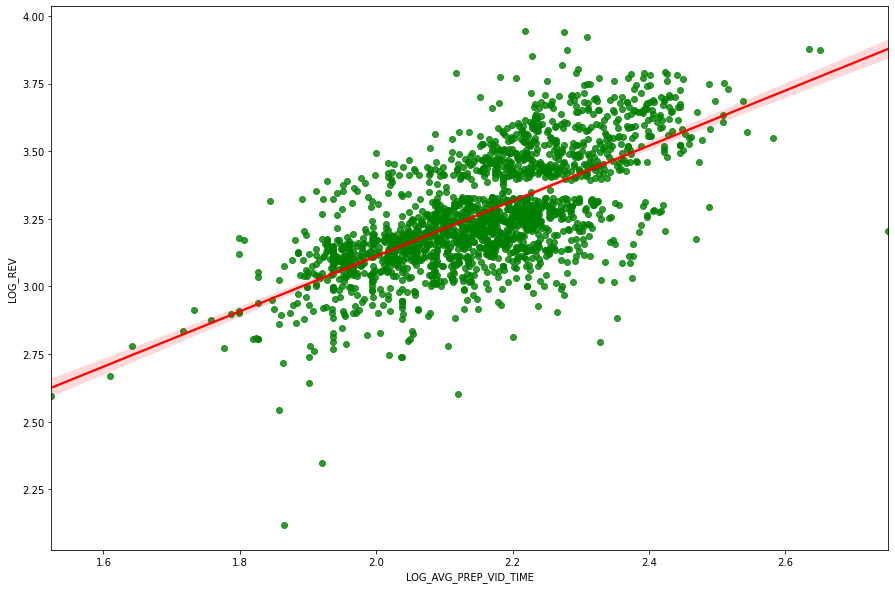


We can visually identify the relationship between revenue and average time spent watching videos. Log tranforming revenue and average time spent watching videos 
resulted in a linear trend that can be easily modeled using linear regression. It is important to understand the interpretation of the coefficient 




Classification model INSIGHTS:

--> AUC = 0.892
 
 • Specifically target customers with short number of names (3 or less) with marketing campaigs aided at accepting 'Halfway There" offer.
 
 Once customers have registered in the mobile or pc APP, inmediatelly classify them according to their number of names and focus specific marketing campaigns.
 
 

CONCLUSIONS:

Analytics should result in actionable business desicions. Apprentice Chef should leverage it's predictive analytics and classifications models provided to 
identify best 'next-steps'. Halfway There can be a succesfull idea if we focus on targeting the right group of clients. Modifications in the  AC APP can result i

In [182]:
#Insights
print(f"""

At Apprentice Chef we want to be data-driven and analyze our customer behaviour in order to further improve our business and offerings. Leveraging a linear regression model and a GBM model (or many decision trees), we found great value in predicting but also analyzing important insights.


REVENUE insights:

 --> R-squared value = {round(ard_test_score,3)}

Average preparation video time (+ effect)

• Grab Viewers in the First 3-5 Seconds.

Issues with low watching times are directly related with not being captivated in the first 5-10 secs. No intro or opening credits, straight to the most engaging opening visual to grab attention. They’re busy professionals.




Total Meals Ordered/ Unique meals purchased (+ effect)

• Set a limit for amount of unique meal sets or charge for extra unique meal sets after 3 categories. This way we increase our meals ordered/unique meals ratio, translating in improved revenues.



Let’s visualize Average preparation video time relation with revenue. 

Since we used two transformed variables, the interpretation of the result basically means that a 1% increase in avg-prep-vid-time produces a 0.53% increase in revenue, keeping everything constant.

 """)

fig, ax = plt.subplots(figsize = (15, 10))


g = sns.regplot(x=dataset['LOG_AVG_PREP_VID_TIME'],
                y=dataset['LOG_REV'],
                color='g',
                line_kws={'color':'red'})

plt.show()

print(f"""
We can visually identify the relationship between revenue and average time spent watching videos. Log tranforming revenue and average time spent watching videos 
resulted in a linear trend that can be easily modeled using linear regression. It is important to understand the interpretation of the coefficient 




Classification model INSIGHTS:

--> AUC = {round(gbm_tuned_3_auc,3)}
 
 • Specifically target customers with short number of names (3 or less) with marketing campaigs aided at accepting 'Halfway There" offer.
 
 Once customers have registered in the mobile or pc APP, inmediatelly classify them according to their number of names and focus specific marketing campaigns.
 
 

CONCLUSIONS:

Analytics should result in actionable business desicions. Apprentice Chef should leverage it's predictive analytics and classifications models provided to 
identify best 'next-steps'. Halfway There can be a succesfull idea if we focus on targeting the right group of clients. Modifications in the  AC APP can result in
improvements in revenue, creating engaging and interesting videos as well es removing excessive options for unique meals.
""")

